In [1]:
!pip install kaggle

In [2]:
!mkdir -p /root/.kaggle
!scp kaggle.json /root/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c digit-recognizer

In [5]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

In [7]:
from sklearn.metrics import confusion_matrix
import random

In [8]:
data = pd.read_csv("train.csv", dtype=np.float32)

In [ ]:
print("Number of training:", data.shape[0])

Number of training: 42000


In [ ]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.isnull().any().describe()

,0
count,785
unique,1
top,False
freq,785


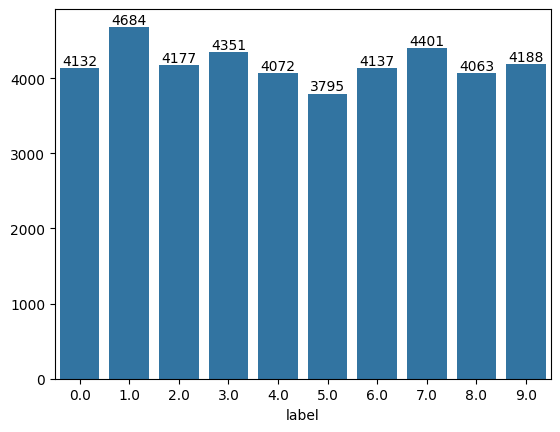

In [ ]:
ax = sns.barplot(x=data['label'].value_counts().index, y=data['label'].value_counts().values)
ax.bar_label(ax.containers[0], fontsize=10);

In [9]:
X = data.drop("label", axis=1).values/255.0
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
def plot_sample_images(X, y, ncols=5, num=25):
    num = int(min(num, len(y)))
    nrows = math.ceil(num / ncols)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols, nrows))
    fig.subplots_adjust(hspace=0.8)
    for i, ax in enumerate(axes.flatten()):
        if i < num:
            ax.imshow(X.max()-X[i].reshape(28, 28), cmap="gray")
            ax.set_title(str(y[i]))
        ax.axis('off')
    plt.show()

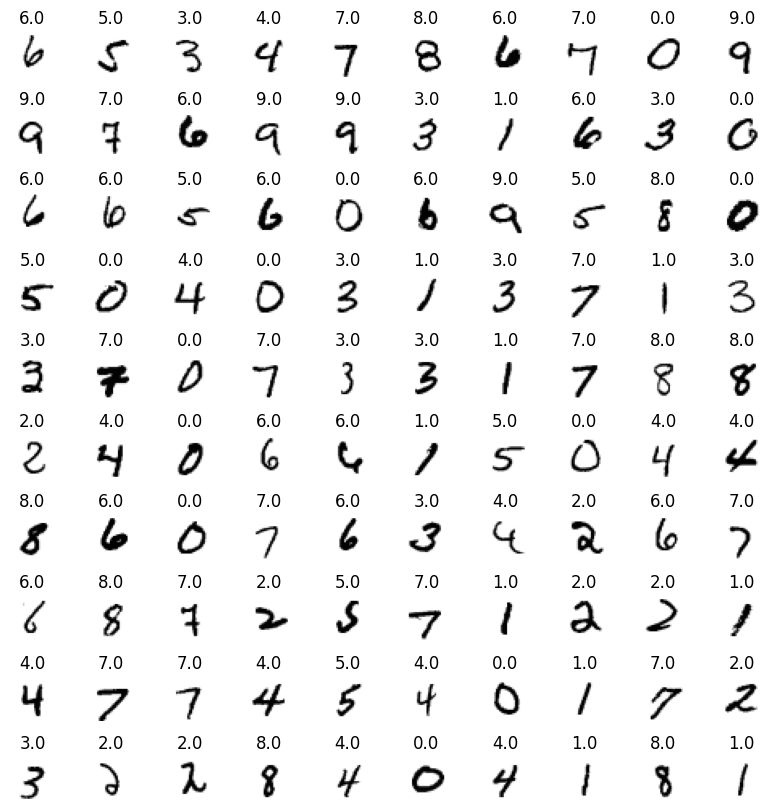

In [ ]:
plot_sample_images(X_train, y_train, ncols=10, num=100)

In [10]:
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, Lambda
from keras.optimizers import AdamW
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available")
    else:
        print("No GPU found, using CPU")

check_gpu()

GPU is available


In [12]:
num_epochs = 6

In [13]:
X_train_keras = X_train.reshape(-1,28,28,1)
y_train_keras = to_categorical(y_train, 10)

X_test_keras = X_test.reshape(-1,28,28,1)
y_test_keras = to_categorical(y_test, 10)

In [14]:
# Аугментация данных (повороты, сдвиги, масштабирование, шум)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

In [15]:
# Функция для добавления шума
def add_noise(img):
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1)  # Генерируем случайный шум
    img = img + noise
    img = tf.clip_by_value(img, 0.0, 1.0)  # Ограничиваем значения от 0 до 1
    return img

In [16]:
# Добавляем слой с шумом
noise_layer = Lambda(lambda x: add_noise(x))

In [17]:
model = Sequential()
model.add(noise_layer)  # Аугментация шума

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# optimizer
optimizer = AdamW()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
train_generator = datagen.flow(X_train_keras, y_train_keras, batch_size=64)

In [20]:
#history = model.fit(X_train_keras, y_train_keras, epochs=num_epochs, validation_data = (X_test_keras, y_test_keras))
history = model.fit(train_generator, epochs=num_epochs, validation_data=(X_test_keras, y_test_keras))

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7600 - loss: 0.7313 - val_accuracy: 0.9806 - val_loss: 0.0638
Epoch 2/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9486 - loss: 0.1748 - val_accuracy: 0.9835 - val_loss: 0.0488
Epoch 3/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9608 - loss: 0.1252 - val_accuracy: 0.9854 - val_loss: 0.0525
Epoch 4/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9692 - loss: 0.1013 - val_accuracy: 0.9882 - val_loss: 0.0387
Epoch 5/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9724 - loss: 0.0932 - val_accuracy: 0.9889 - val_loss: 0.0356
Epoch 6/6
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9758 - loss: 0.0832 - val_accuracy: 0.9896 - val_loss: 0.0267


In [21]:
# Выводим Accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Accuracy: 0.9761
Final Validation Accuracy: 0.9896


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


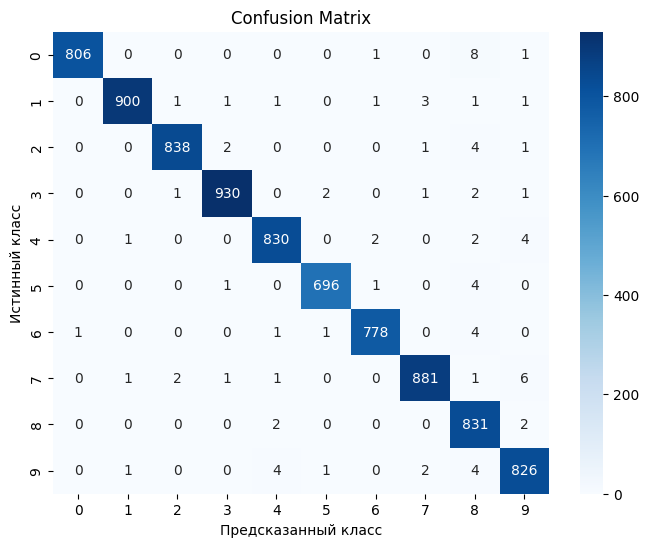

In [30]:
# Получаем предсказания для тестового набора
y_pred = model.predict(X_test_keras)
y_pred_classes = y_pred.argmax(axis=1)  # Преобразуем one-hot в метки классов
y_true_classes = y_test  # Преобразуем one-hot в метки классов

# Строим confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion Matrix")
plt.show()

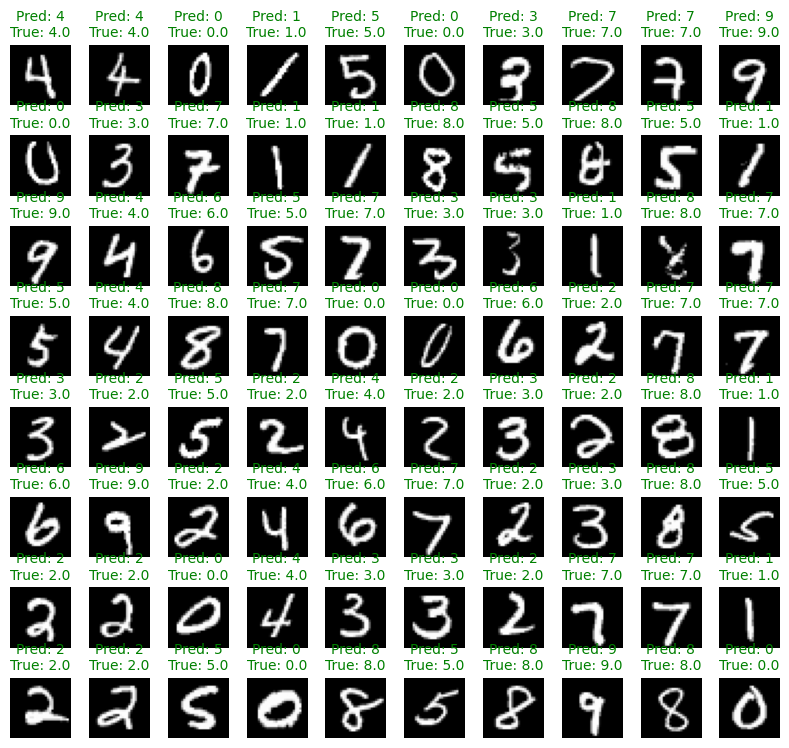

In [31]:
# Выбираем случайные 80 изображений
num_images = 80
random_indices = random.sample(range(len(X_test)), num_images)
X_sample = X_test[random_indices]  # Берем случайные изображения
y_true_sample = y_true_classes[random_indices]  # Истинные классы
y_pred_sample = y_pred_classes[random_indices]  # Предсказанные классы

# Визуализация
ncols = 10
nrows = num_images // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows + 1))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        ax.imshow(X_sample[i].reshape(28, 28), cmap="gray")
        ax.axis("off")

        # Подготовка заголовка (зеленый = правильно, красный = ошибка)
        color = "green" if y_true_sample[i] == y_pred_sample[i] else "red"
        title = f"Pred: {y_pred_sample[i]}\nTrue: {y_true_sample[i]}"
        ax.set_title(title, color=color, fontsize=10)

plt.show()

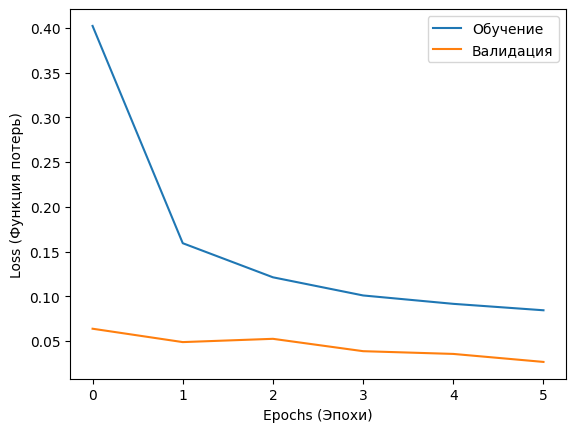

In [25]:
# Графики обучения
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.xlabel('Epochs (Эпохи)')
plt.ylabel('Loss (Функция потерь)')
plt.legend()
plt.show()

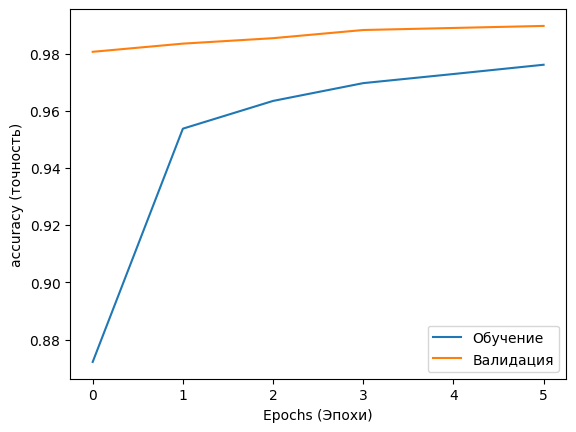

In [32]:
plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.xlabel('Epochs (Эпохи)')
plt.ylabel('accuracy (точность)')
plt.legend()
plt.show()

In [37]:
import cv2
import os

In [174]:
# Путь к папке с изображениями
image_dir = "/content/custom-digits"

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Читаем изображение в градациях серого

    # Инвертируем цвета (MNIST использует черный фон)
    img = 255 - img

    # Находим контуры и обрезаем лишний фон
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        img = img[y:y+h, x:x+w]

    # Утолщение линий
    kernel = np.ones((11, 11), np.uint8)  # Ядро для дилатации
    img = cv2.dilate(img, kernel, iterations=1)

    # Добавляем небольшую рамку для центрирования цифры
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)

    # Изменяем размер и нормализуем
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img = img.reshape(28, 28, 1)  # Преобразуем в формат (28,28,1)
    return img


In [175]:
# Аугментация данных
datagen = ImageDataGenerator(rotation_range=45, fill_mode="nearest")

# Загружаем изображения
X_custom = []
y_custom = []
image_filenames = []

In [176]:
for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        image_path = os.path.join(image_dir, filename)
        processed_img = preprocess_image(image_path)
        digit_label = int([char for char in filename if char.isdigit()][0])

        # Добавляем исходное изображение
        X_custom.append(processed_img)
        y_custom.append(digit_label)
        image_filenames.append(filename)

        # Создаем дополнительные аугментированные версии
        img_batch = np.expand_dims(processed_img, axis=0)
        aug_iter = datagen.flow(img_batch, batch_size=1)
        for i in range(4):  # Генерируем 4 поворота на каждое изображение
            aug_img = next(aug_iter)[0]
            X_custom.append(aug_img)
            y_custom.append(digit_label)
            image_filenames.append(f"{filename}_aug{i}")

# Преобразуем в массив numpy
X_custom = np.array(X_custom)
y_custom = np.array(y_custom)

In [177]:
# Делаем предсказание
predictions = model.predict(X_custom)
predicted_classes = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


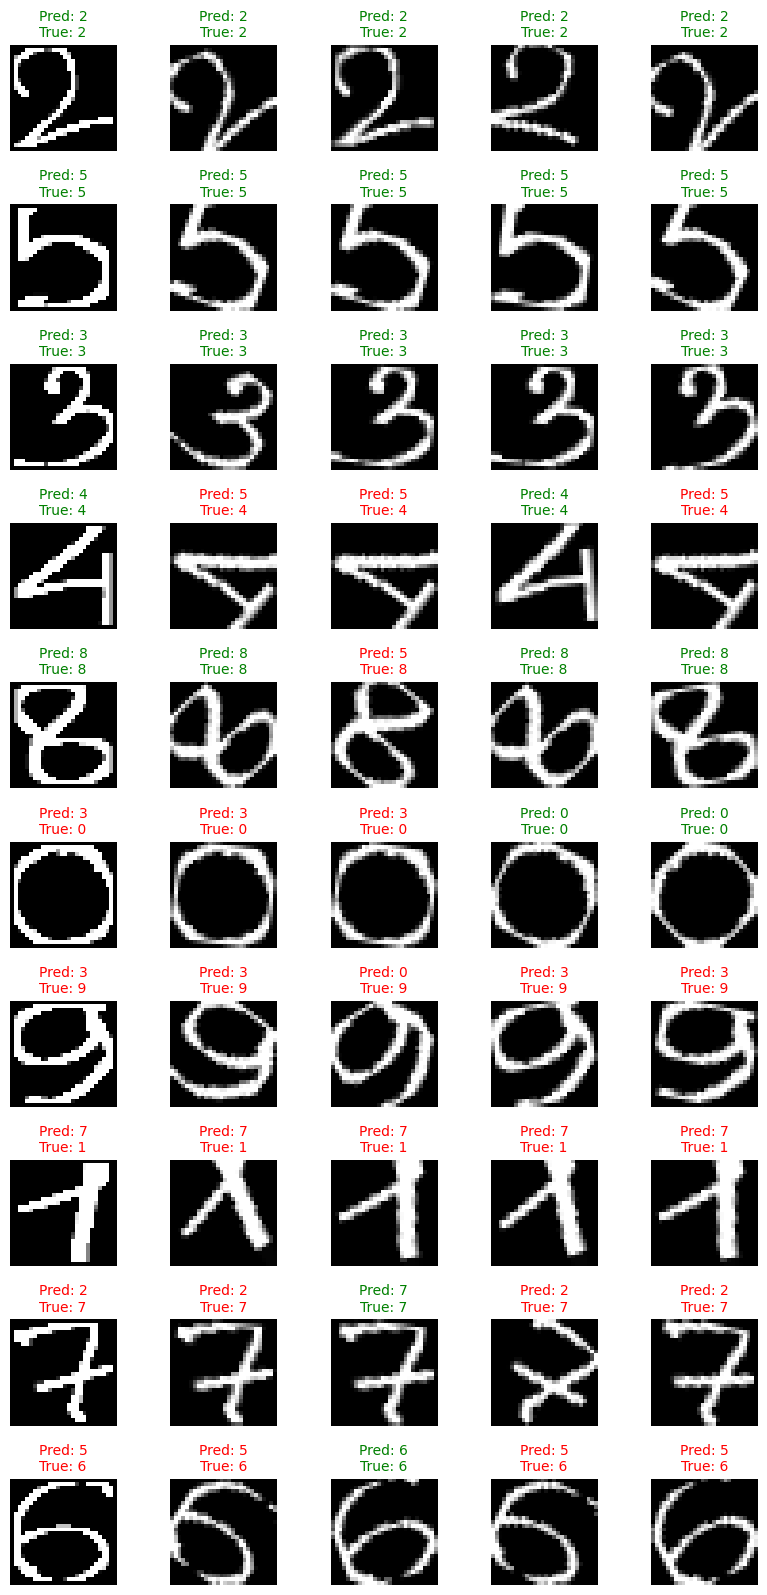

In [178]:
# Визуализация результатов
ncols = 5
nrows = int(np.ceil(len(X_custom) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flatten()):
    if i < len(X_custom):
        ax.imshow(X_custom[i].squeeze(), cmap="gray")
        ax.axis("off")

        color = "green" if y_custom[i] == predicted_classes[i] else "red"
        title = f"Pred: {predicted_classes[i]}\nTrue: {y_custom[i]}"
        ax.set_title(title, color=color, fontsize=10)
    else:
        ax.axis("off")

plt.show()